# Preserving a multi-variable pointwise quantity of interest (QoI) with safeguards

In this example, we compute the wind kinetic energy per unit mass from a dataset of wind components `u` and `v`. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the derived pointwise kinetic energy when compressing the `u` and `v` variables (stacked into one variable). Finally, we apply safeguards to guarantee an error bound on the derived kinetic energy. We also compare the safeguards with the QoI-aware QPET-SPERR compressor.

Stacking `u` and `v` into one variable that is then compressed is possible because `u` and `v` have very similar data distributions.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import humanize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_kinetic_energy(ERA5: xr.Dataset) -> xr.DataArray:
    ERA5_KE = 0.5 * (np.square(ERA5["u"]) + np.square(ERA5["v"]))
    ERA5_KE.attrs.update(
        long_name="wind kinetic energy per unit mass", units="m**2 s**-2"
    )

    return ERA5_KE

In [5]:
ERA5_KE = compute_kinetic_energy(ERA5)

In [6]:
def compute_corrections_percentage(my_ERA5: xr.Dataset, orig_ERA5: xr.Dataset) -> float:
    neq = np.sum(my_ERA5 != orig_ERA5)
    return int(neq.u + neq.v) / int(orig_ERA5.u.size + orig_ERA5.v.size)

In [7]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [8]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [9]:
def plot_kinetic_energy(
    my_ERA5: xr.Dataset,
    cr,
    chart,
    title,
    span,
    ke_eb_abs,
    error=False,
    corr=None,
    my_ERA5_it=None,
    cr_it=None,
):
    import copy

    import dask

    my_ERA5_KE = compute_kinetic_energy(my_ERA5)

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_KE - ERA5_KE).compute()

        err_inf_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_inf_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
        err_inf_KE = np.amax(np.abs(my_ERA5_KE - ERA5_KE))
        err_2_KE = np.sqrt(np.mean(np.square(my_ERA5_KE - ERA5_KE)))
        err_v = np.mean(~(np.abs(my_ERA5_KE - ERA5_KE) <= ke_eb_abs))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        # plot the square root of kinetic energy to better capture scale
        da = np.sqrt(my_ERA5_KE)
        da.attrs.update(long_name=f"sqrt({da.long_name})", units="m**1 s**-1")

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 21)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(np.linspace(0, span, 21))
        style._legend_kwargs["ticks"] = np.linspace(0, span, 5)
        style._colors = "viridis"

    extend_left = np.nanmin(da) < (-span if error else 0)
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-12)

        if corr is not None:
            with xr.set_options(keep_attrs=True):
                da_hatch = (my_ERA5["u"] == corr["u"]) & (my_ERA5["v"] == corr["v"])

            da_hatch = da_hatch.copy(
                data=dask.array.from_array(da_hatch.values)
                .rechunk(4)
                .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                .compute()
            )

            with plt.rc_context(
                {
                    "hatch.color": (1.0, 1.0, 1.0, 0.5),
                    "hatch.linewidth": 0.5,
                }
            ):
                chart.contourf(
                    x=np.broadcast_to(
                        da_hatch.longitude.values.reshape(1, -1), da_hatch.shape
                    ),
                    y=np.broadcast_to(
                        da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape
                    ),
                    z=da_hatch.values,
                    colors=["none"],
                    levels=[-0.5, 0.9, 1.5],
                    hatches=["xxx" if corr is None else "O", None],
                    legend_style=None,
                    zorder=-11,
                )

            if my_ERA5_it is not None:
                with xr.set_options(keep_attrs=True):
                    da_hatch_it = (my_ERA5_it["u"] == corr["u"]) & (
                        my_ERA5_it["v"] == corr["v"]
                    )

                da_hatch_it = da_hatch_it.copy(
                    data=dask.array.from_array(da_hatch_it.values)
                    .rechunk(4)
                    .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                    .compute()
                )

                with plt.rc_context(
                    {
                        "hatch.color": (144 / 255, 238 / 255, 144 / 255, 0.5),
                        "hatch.linewidth": 0.25,
                    }
                ):
                    chart.contourf(
                        x=np.broadcast_to(
                            da_hatch_it.longitude.values.reshape(1, -1),
                            da_hatch_it.shape,
                        ),
                        y=np.broadcast_to(
                            da_hatch_it.latitude.values.reshape(-1, 1),
                            da_hatch_it.shape,
                        ),
                        z=da_hatch_it.values,
                        colors=["none"],
                        levels=[-0.5, 0.9, 1.5],
                        hatches=["O", None],
                        legend_style=None,
                        zorder=-11,
                    )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        if my_ERA5_it is not None:
            corr_it = (
                None
                if corr is None
                else compute_corrections_percentage(my_ERA5_it, corr)
            )

        corr = None if corr is None else compute_corrections_percentage(my_ERA5, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_inf_U:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{v}}}})$={err_inf_V:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{KE}}}})$={err_inf_KE:.03}  "
            + rf"$L_{{{{2}}}}(\hat{{{{KE}}}})$={err_2_KE:.03}"
            + "\n"
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                    + (
                        ""
                        if corr_it is None
                        else (
                            f" ({0 if corr == 0 else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + '%'})"
                        )
                    )
                )
            )
        )
    else:
        chart.title(f"{title}\n\n")

    t = chart.ax.text(
        0.95,
        0.9,
        (
            f"x {np.round(cr, 2)}"
            + ("" if cr_it is None else f" (x {np.round(cr_it, 2)})")
        )
        if error
        else humanize.naturalsize(ERA5["u"].nbytes + ERA5["v"].nbytes, binary=True),
        ha="right",
        va="top",
        transform=chart.ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(
        da.values.flatten(), range=(-span if error else 0, span), bins=20
    )
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    if error:
        if extend_left:
            cb._extend_patches[0].set_hatch("xx")
            cb._extend_patches[0].set_ec("white")
        cb.ax.fill_between(
            [-span, -ke_eb_abs], *cb.ax.get_ylim(), hatch="xx", ec="w", fc="none", lw=0
        )
        cb.ax.fill_between(
            [ke_eb_abs, span], *cb.ax.get_ylim(), hatch="xx", ec="w", fc="none", lw=0
        )
        if extend_right:
            cb._extend_patches[-1].set_hatch("xx")
            cb._extend_patches[-1].set_ec("white")
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
        **(
            dict(
                hatch=["xx" if np.abs(m) > ke_eb_abs else "" for m in midpoints],
                ec="white",
                lw=0,
            )
            if error
            else dict()
        ),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < (-span if error else 0)),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
            **(
                dict(
                    hatch="xx",
                    ec="white",
                    lw=0,
                )
                if error
                else dict()
            ),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > span),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
            **(
                dict(
                    hatch="xx",
                    ec="white",
                    lw=0,
                )
                if error
                else dict()
            ),
        )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        (-span if error else 0) - (bins[-1] - bins[-2]) * extend_left,
        span + (bins[-1] - bins[-2]) * extend_right,
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [10]:
def table_kinetic_energy(
    my_ERA5: xr.Dataset,
    cr,
    title,
    ke_eb_abs,
    corr,
    my_ERA5_it,
    cr_it,
) -> pd.DataFrame:
    my_ERA5_KE = compute_kinetic_energy(my_ERA5)
    my_ERA5_KE_it = compute_kinetic_energy(my_ERA5_it)

    err_inf_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
    err_inf_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
    err_inf_KE = np.amax(np.abs(my_ERA5_KE - ERA5_KE))
    err_2_KE = np.sqrt(np.mean(np.square(my_ERA5_KE - ERA5_KE)))

    err_v = np.mean(~(np.abs(my_ERA5_KE - ERA5_KE) <= ke_eb_abs))
    err_v = (
        0
        if err_v == 0
        else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + "%"
    )

    err_inf_U_it = np.amax(np.abs(my_ERA5_it["u"] - ERA5["u"]))
    err_inf_V_it = np.amax(np.abs(my_ERA5_it["v"] - ERA5["v"]))
    err_inf_KE_it = np.amax(np.abs(my_ERA5_KE_it - ERA5_KE))
    err_2_KE_it = np.sqrt(np.mean(np.square(my_ERA5_KE_it - ERA5_KE)))

    err_v_it = np.mean(~(np.abs(my_ERA5_KE_it - ERA5_KE) <= ke_eb_abs))
    err_v_it = (
        0
        if err_v_it == 0
        else np.format_float_positional(100 * err_v_it, precision=1, min_digits=1) + "%"
    )

    corr_it = compute_corrections_percentage(my_ERA5_it, corr)
    corr = compute_corrections_percentage(my_ERA5, corr)

    corr = (
        0
        if corr == 0
        else np.format_float_positional(100 * corr, precision=1, min_digits=1) + "%"
    )
    corr_it = (
        0
        if corr_it == 0
        else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + "%"
    )

    return pd.DataFrame(
        {
            "Compressor": [title, title],
            "Safeguards": ["one-shot", "iterative"],
            r"$L_{\infty}(\hat{u})$": [
                f"{err_inf_U:.03}",
                f"{err_inf_U_it:.03}",
            ],
            r"$L_{\infty}(\hat{v})$": [
                f"{err_inf_V:.03}",
                f"{err_inf_V_it:.03}",
            ],
            r"$L_{\infty}(\hat{KE})$": [
                f"{err_inf_KE:.03}",
                f"{err_inf_KE_it:.03}",
            ],
            r"$L_{2}(\hat{KE})$": [
                f"{err_2_KE:.03}",
                f"{err_2_KE_it:.03}",
            ],
            "V": [err_v, err_v_it],
            "C": [corr, corr_it],
            "CR": [
                f"x {np.round(cr, 2)}",
                f"x {np.round(cr_it, 2)}",
            ],
        }
    )

In [11]:
# Since numcodecs-safeguards only supports single-variable safeguarding, we
# stack the u and v variables into a combined variable.
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

## Compressing u and v with lossy compressors

We configure each compressor with an absolute error bound of 0.125 m/s over the u-v array, which seems to provide similar errors on the derived kinetic energy.

In [12]:
eb_abs = 0.125

In [13]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_UV_zfp_enc = zfp.encode(ERA5_UV)
ERA5_UV_zfp = zfp.decode(ERA5_UV_zfp_enc)

ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))
ERA5_zfp_cr = ERA5_UV.nbytes / ERA5_UV_zfp_enc.nbytes

In [14]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_UV_sz3_enc = sz3.encode(ERA5_UV)
ERA5_UV_sz3 = sz3.decode(ERA5_UV_sz3_enc)

ERA5_sz3 = ERA5.copy(data=dict(u=ERA5_UV_sz3[..., 0], v=ERA5_UV_sz3[..., 1]))
ERA5_sz3_cr = ERA5_UV.nbytes / ERA5_UV_sz3_enc.nbytes

In [15]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_UV_sperr_enc = sperr.encode(ERA5_UV)
ERA5_UV_sperr = sperr.decode(ERA5_UV_sperr_enc)

ERA5_sperr = ERA5.copy(data=dict(u=ERA5_UV_sperr[..., 0], v=ERA5_UV_sperr[..., 1]))
ERA5_sperr_cr = ERA5_UV.nbytes / ERA5_UV_sperr_enc.nbytes

In [16]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

ERA5_UV_zero_enc = zero.encode(ERA5_UV)
ERA5_UV_zero = zero.decode(ERA5_UV_zero_enc)

ERA5_zero = ERA5.copy(data=dict(u=ERA5_UV_zero[..., 0], v=ERA5_UV_zero[..., 1]))

## Compressing u and v using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived kinetic energy, choosing an error bound that is comparible to the errors produced by the lossy compression methods above.

The kinetic energy computation is translated into a quantity of interest. Even though kinetic energy is a pointwise quantity, stacking `u` and `v` into a single variable means that we now compute the kinetic energy over a two-element `(u, v)` local neighbourhood.

In [17]:
ke_eb_abs = 1.0

In [18]:
from numcodecs_safeguards import SafeguardsCodec

ERA5_sg = dict()
ERA5_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="0.5 * (square(X[0]) + square(X[1]))",
                type="abs",
                eb=ke_eb_abs,
                neighbourhood=[
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
    )

    ERA5_UV_sg_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg = sg.decode(ERA5_UV_sg_enc)

    ERA5_sg[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1])
    )
    ERA5_sg_cr[codec.codec_id] = ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_enc).nbytes

In [19]:
ERA5_sg_it = dict()
ERA5_sg_it_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg_it = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="0.5 * (square(X[0]) + square(X[1]))",
                type="abs",
                eb=ke_eb_abs,
                neighbourhood=[
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
        # use iteration to refine the corrections
        compute=dict(unstable_iterative=True),
    )

    ERA5_UV_sg_it_enc = sg_it.encode(ERA5_UV)
    ERA5_UV_sg_it = sg_it.decode(ERA5_UV_sg_it_enc)

    ERA5_sg_it[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg_it[..., 0], v=ERA5_UV_sg_it[..., 1])
    )
    ERA5_sg_it_cr[codec.codec_id] = (
        ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_it_enc).nbytes
    )

## Compressing u and v using QPET-SPERR

We similarly configure QPET-SPERR to bound the pointwise absolute error on the derived kinetic energy, choosing an error bound that is comparible to the errors produced by the lossy compression methods above.

The kinetic energy computation is translated into a quantity of interest. We utilize QPET-SPERR's block-mean mode to bound the mean of $x^2$ over the stacked $[u, v]$ axis, which bounds $0.5 \cdot (u^2 + v^2)$, i.e. the kinetic energy.

In [20]:
from numcodecs_wasm_qpet_sperr import QpetSperr

qpet = QpetSperr(
    mode="qoi-symbolic", qoi="x^2", qoi_block_size=(1, 1, 2), qoi_pwe=ke_eb_abs
)

ERA5_UV_qpet_enc = qpet.encode(ERA5_UV)
ERA5_UV_qpet = qpet.decode(ERA5_UV_qpet_enc)

ERA5_qpet = ERA5.copy(data=dict(u=ERA5_UV_qpet[..., 0], v=ERA5_UV_qpet[..., 1]))
ERA5_qpet_cr = ERA5_UV.nbytes / ERA5_UV_qpet_enc.nbytes

Tuning eb with qoi
current_eb = 0.0385615, current_br = 4.49219
current_eb = 0.02754, current_br = 4.92578
current_eb = 0.02137, current_br = 5.29688
current_eb = 0.0176515, current_br = 5.58984
current_eb = 0.0162742, current_br = 5.65625
current_eb = 0.0154391, current_br = 5.79297
current_eb = 0.0145696, current_br = 5.84375
Selected quantile: 0.200005
Best abs eb:  0.0385615
Tuning eb with qoi
current_eb = 0.0385615, current_br = 5.21484
current_eb = 0.0273392, current_br = 5.52734
current_eb = 0.0213517, current_br = 5.9375
current_eb = 0.0186124, current_br = 6.11328
current_eb = 0.0170938, current_br = 6.15625
current_eb = 0.0153922, current_br = 6.39062
current_eb = 0.0140332, current_br = 6.45312
Selected quantile: 0.200005
Best abs eb:  0.0385615
Tuning eb with qoi
current_eb = 0.0294802, current_br = 5.92969
current_eb = 0.0213552, current_br = 5.86328
current_eb = 0.0166734, current_br = 6.23047
current_eb = 0.0139531, current_br = 6.5
current_eb = 0.0129703, current_br = 6

## Visual comparison of the error distributions for the derived kinetic energy

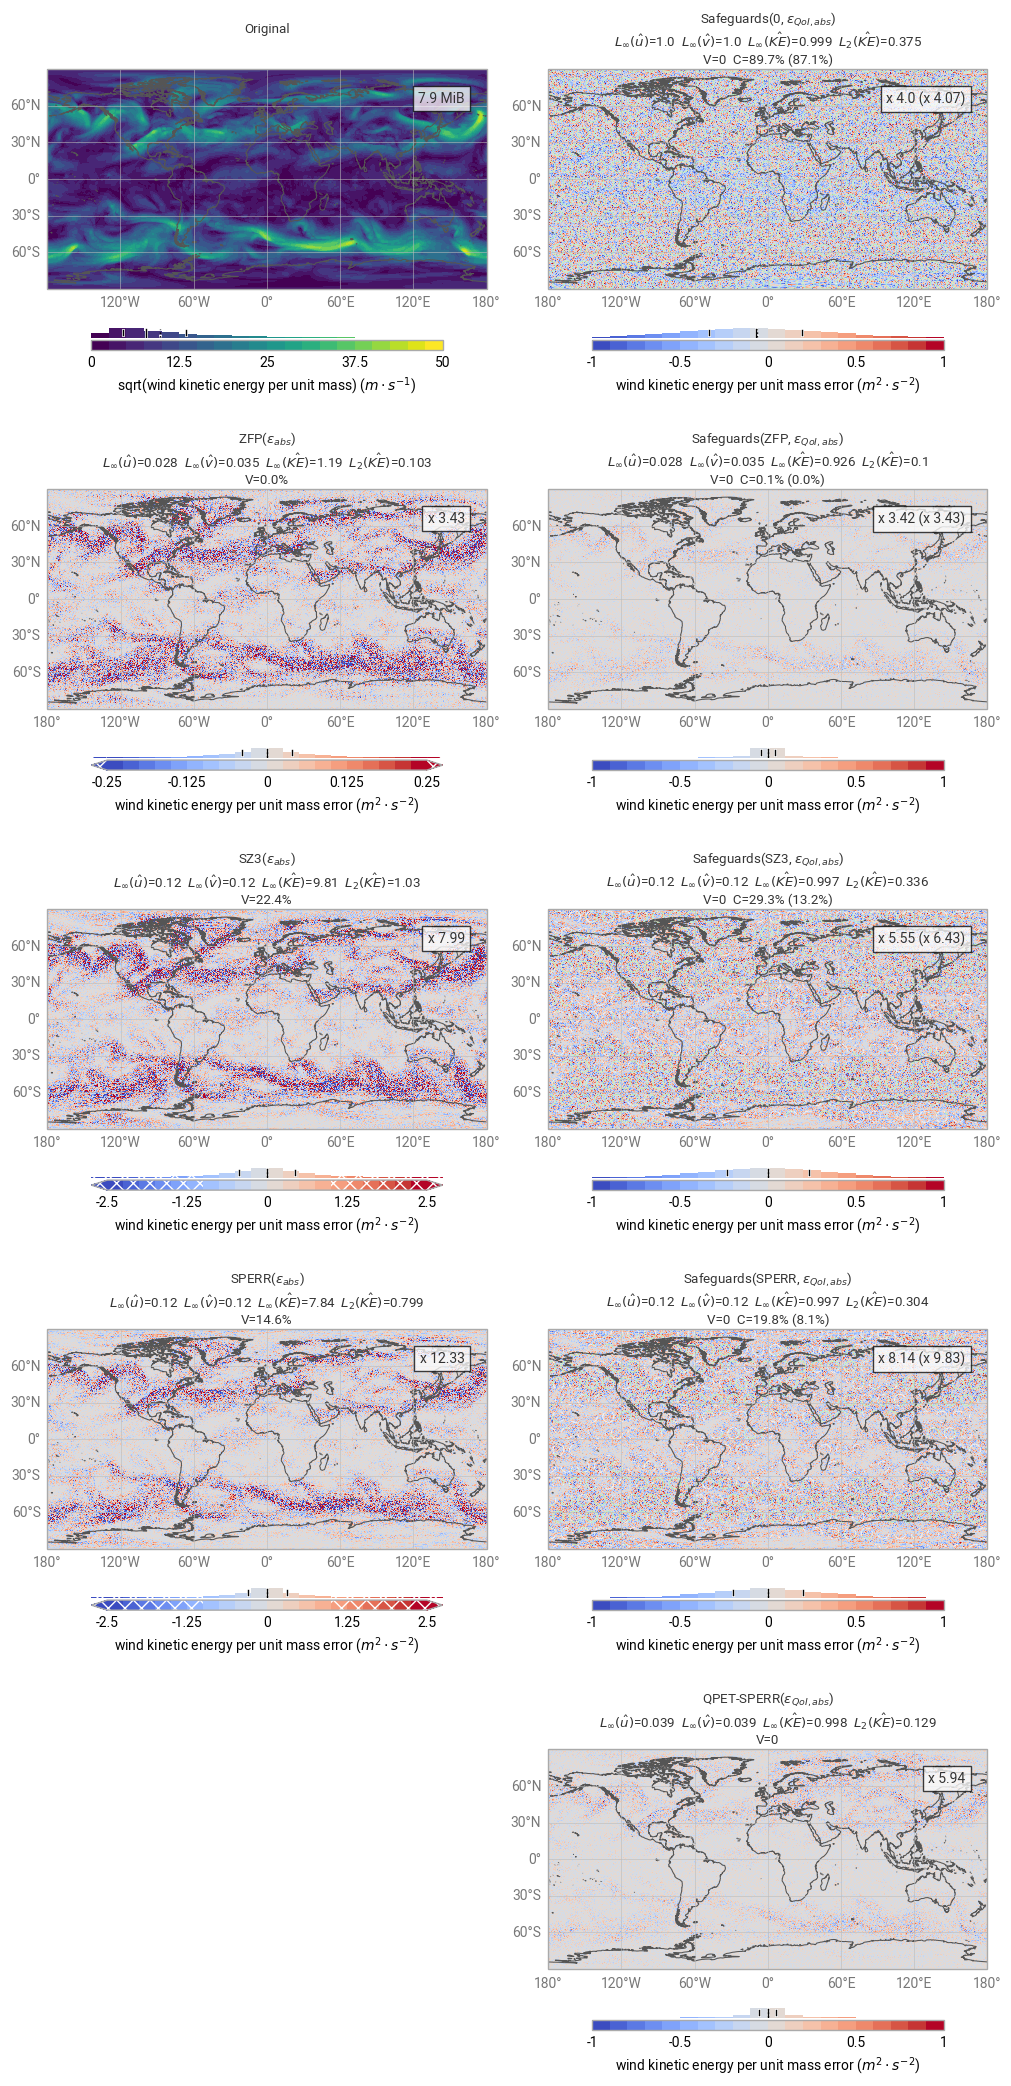

In [21]:
fig = earthkit.plots.Figure(
    size=(10, 21),
    rows=5,
    columns=2,
)

plot_kinetic_energy(
    ERA5, 1.0, fig.add_map(0, 0), "Original", span=50, ke_eb_abs=ke_eb_abs
)
plot_kinetic_energy(
    ERA5_zfp,
    ERA5_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=0.25,
    ke_eb_abs=ke_eb_abs,
    error=True,
)
plot_kinetic_energy(
    ERA5_sz3,
    ERA5_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=2.5,
    ke_eb_abs=ke_eb_abs,
    error=True,
)
plot_kinetic_energy(
    ERA5_sperr,
    ERA5_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=2.5,
    ke_eb_abs=ke_eb_abs,
    error=True,
)

plot_kinetic_energy(
    ERA5_sg["zero"],
    ERA5_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_zero,
    my_ERA5_it=ERA5_sg_it["zero"],
    cr_it=ERA5_sg_it_cr["zero"],
)
plot_kinetic_energy(
    ERA5_sg["zfp.rs"],
    ERA5_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_zfp,
    my_ERA5_it=ERA5_sg_it["zfp.rs"],
    cr_it=ERA5_sg_it_cr["zfp.rs"],
)
plot_kinetic_energy(
    ERA5_sg["sz3.rs"],
    ERA5_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_sz3,
    my_ERA5_it=ERA5_sg_it["sz3.rs"],
    cr_it=ERA5_sg_it_cr["sz3.rs"],
)
plot_kinetic_energy(
    ERA5_sg["sperr.rs"],
    ERA5_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_sperr,
    my_ERA5_it=ERA5_sg_it["sperr.rs"],
    cr_it=ERA5_sg_it_cr["sperr.rs"],
)

plot_kinetic_energy(
    ERA5_qpet,
    ERA5_qpet_cr,
    fig.add_map(4, 1),
    r"QPET-SPERR($\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
)

fig.save("kinetic-energy.pdf")

In [22]:
ke_sg_table = pd.concat(
    [
        table_kinetic_energy(
            ERA5_sg["zero"],
            ERA5_sg_cr["zero"],
            r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
            ke_eb_abs,
            ERA5_zero,
            ERA5_sg_it["zero"],
            ERA5_sg_it_cr["zero"],
        ),
        table_kinetic_energy(
            ERA5_sg["zfp.rs"],
            ERA5_sg_cr["zfp.rs"],
            r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
            ke_eb_abs,
            ERA5_zfp,
            ERA5_sg_it["zfp.rs"],
            ERA5_sg_it_cr["zfp.rs"],
        ),
        table_kinetic_energy(
            ERA5_sg["sz3.rs"],
            ERA5_sg_cr["sz3.rs"],
            r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
            ke_eb_abs,
            ERA5_sz3,
            ERA5_sg_it["sz3.rs"],
            ERA5_sg_it_cr["sz3.rs"],
        ),
        table_kinetic_energy(
            ERA5_sg["sperr.rs"],
            ERA5_sg_cr["sperr.rs"],
            r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
            ke_eb_abs,
            ERA5_sperr,
            ERA5_sg_it["sperr.rs"],
            ERA5_sg_it_cr["sperr.rs"],
        ),
    ]
).set_index(["Compressor", "Safeguards"])

ke_sg_table.to_latex("kinetic-energy.tex", escape=True)

ke_sg_table

$L_{\infty}(\hat{u})$  \
Compressor                                Safeguards                         
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                     1.0   
                                          iterative                   1.41   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                   0.028   
                                          iterative                  0.028   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                   0.125   
                                          iterative                  0.125   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                   0.125   
                                          iterative                  0.125   

                                                     $L_{\infty}(\hat{v})$  \
Compressor                                Safeguards                         
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                   0.999   
                                          iterative                   1.73   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                  0.0349   
                                          iterative                 0.0349   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                   0.125   
                                          iterative                  0.125   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                   0.125   
                                          iterative                  0.125   

                                                     $L_{\infty}(\hat{KE})$  \
Compressor                                Safeguards                          
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot                    0.999   
                                          iterative                     1.0   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                    0.926   
                                          iterative                   0.998   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot                    0.997   
                                          iterative                     1.0   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot                    0.997   
                                          iterative                     1.0   

                                                     $L_{2}(\hat{KE})$  V  \
Compressor                                Safeguards                        
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot               0.375  0   
                                          iterative                0.4  0   
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot                 0.1  0   
                                          iterative              0.103  0   
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot               0.336  0   
                                          iterative              0.462  0   
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot               0.304  0   
                                          iterative              0.415  0   

                                                          C      CR  
Compressor                                Safeguards                 
Safeguards(0, $\epsilon_{{QoI,abs}}$)     one-shot    89.7%   x 4.0  
                                          iterative   87.1%  x 4.07  
Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)   one-shot     0.1%  x 3.42  
                                          iterative    0.0%  x 3.43  
Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)   one-shot    29.3%  x 5.55  
                                          iterative   13.2%  x 6.43  
Safeguards(SPERR, $\epsilon_{{QoI,abs}}$) one-shot    19.8%  x 8.14  
                                          iterative    8.1%  x 9.83